In [1]:
import torch
from torch import nn
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchsummary

In [19]:
BASE_PATH = '.'
in_colab = True
need_train = False

In [3]:
import numpy as np

def to_X_y(ds):
    X = ds.iloc[:,1:].values.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y = ds.iloc[:,0].values
    
    return X, y

def to_groups(X, y):
    groups = [X[np.where(y==i)[0]] for i in np.unique(y)]
    
    return groups

def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]

        if match_group:
            b_group_idx = group_idx
            out_score += [1.0]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0.0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0).astype('float32').reshape(-1, 1)

In [9]:
if in_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  BASE_PATH = '/content/drive/My Drive'

train_ds = pd.read_csv('/content/drive/My Drive/cv_data/fashion-mnist_train.csv')

train_groups = to_groups(*to_X_y(train_ds))

Mounted at /content/drive


In [11]:
feature_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
feature_model = feature_model.eval()
feature_model = feature_model.requires_grad_(False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [12]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(244),
    transforms.ToTensor(),
    transforms.Lambda(lambda img: img.expand(3,*img.shape[1:])),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
class SiameseModel(nn.Module):
    def __init__(self, feature_model):
        super().__init__()
        self.feature_model = feature_model
        self.lin1 = nn.Linear(2000, 200)
        self.norm1 = nn.BatchNorm1d(200)
        self.act = nn.ReLU()
        self.lin2 = nn.Linear(200, 20)
        self.lin3 = nn.Linear(20, 1)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x1 = x[0]
        x2 = x[1]
        x1_feat = self.feature_model(x1)
        x2_feat = self.feature_model(x2)
        result = torch.concat((x1_feat, x2_feat), dim=1)
        result = self.lin1(result)
        result = self.norm1(result)
        result = self.act(result)
        result = self.lin2(result)
        result = self.lin3(result)

        return self.sigm(result)

In [14]:
model = SiameseModel(feature_model)
if torch.cuda.is_available():
  model = model.to('cuda')

In [20]:
if not need_train:
  model.load_state_dict(torch.load('/content/drive/My Drive/cv_data/model_params.pt', map_location='cpu'))
else:
  batch_num = 500
  batch_halfsize = 256
  
  optim = torch.optim.Adam(model.parameters(), lr=0.001)
  loss = nn.MSELoss()
  
  for epoch in range(5):
      print(f'Epoch {epoch + 1}')
      epoch_loss = 0
      i = 1
      for im1, im2, l in map(lambda x: gen_random_batch(train_groups, batch_halfsize), range(batch_num)):
          if i%20 == 0:
              print(f'doing {i}-th iteration, avg loss is {epoch_loss/i}')
      
          x1 = torch.stack([preprocess(x) for x in im1])
          x2 = torch.stack([preprocess(x) for x in im2])
          y = torch.tensor(l)
  
          if torch.cuda.is_available():
            x1 = x1.to('cuda')
            x2 = x2.to('cuda')
            y = y.to('cuda')
          
          out = model((x1, x2))
          l = loss(out, y)
          epoch_loss += l.item()
          l.backward()
          optim.step()
          
          i += 1
      print(f'epoch {epoch+1} loss: {epoch_loss}')
      torch.save(model.state_dict(), '/content/drive/My Drive/cv_data/model_params.pt')

In [52]:
im1, im2, l = gen_random_batch(train_groups)
x1 = torch.stack([preprocess(x) for x in im1])
x2 = torch.stack([preprocess(x) for x in im2])
y = torch.tensor(l)

if torch.cuda.is_available():
  x1 = x1.to('cuda')
  x2 = x2.to('cuda')
  y = y.to('cuda')

out = model((x1, x2))
nn.functional.mse_loss(out, y)

tensor(0.0625, device='cuda:0', grad_fn=<MseLossBackward0>)

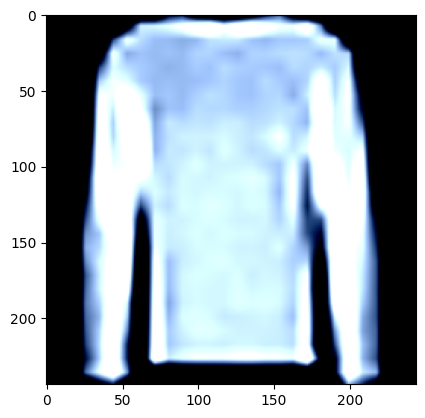

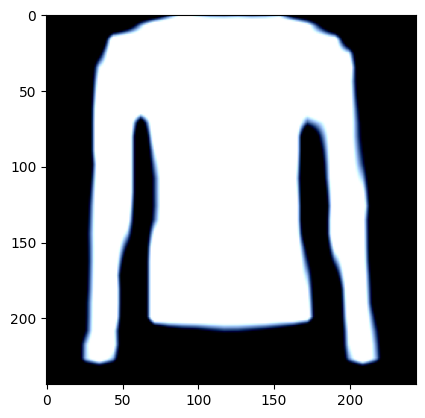

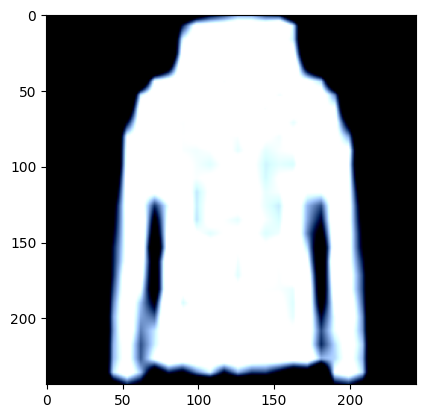

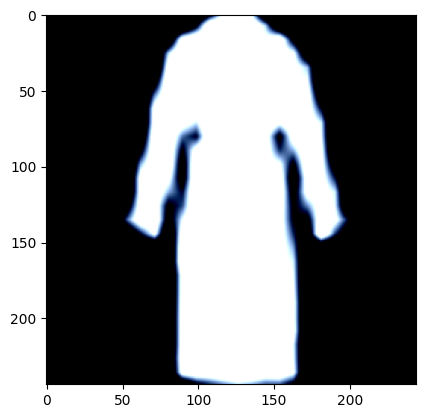

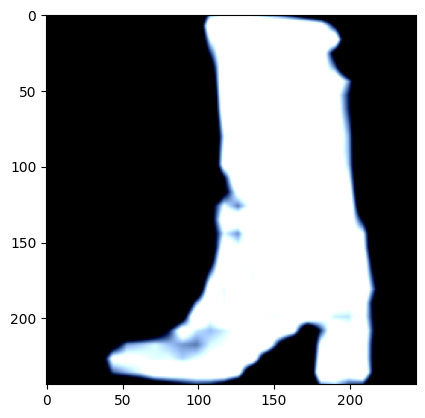

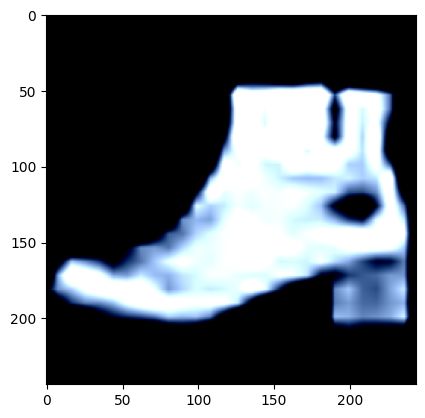

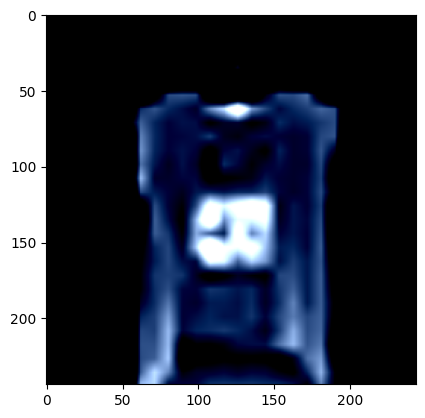

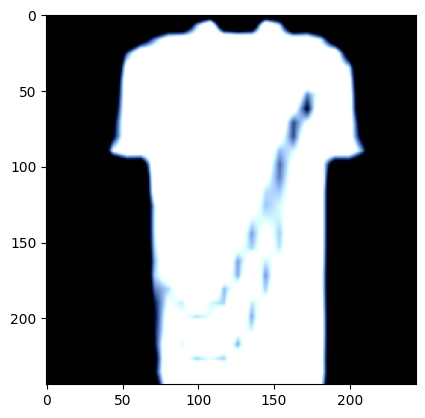

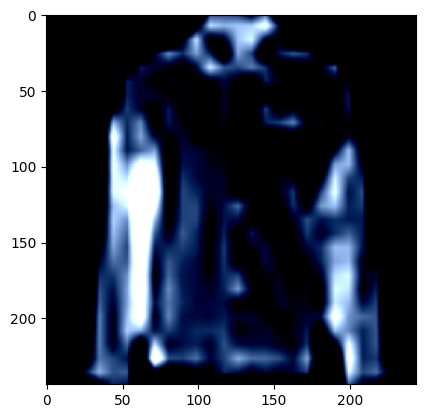

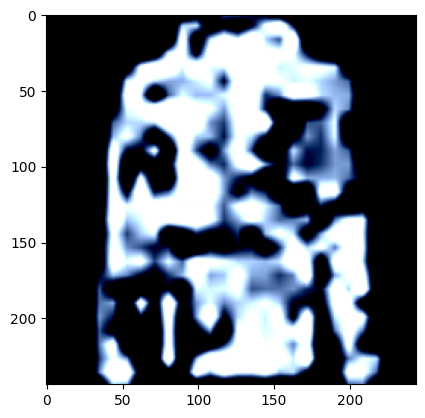

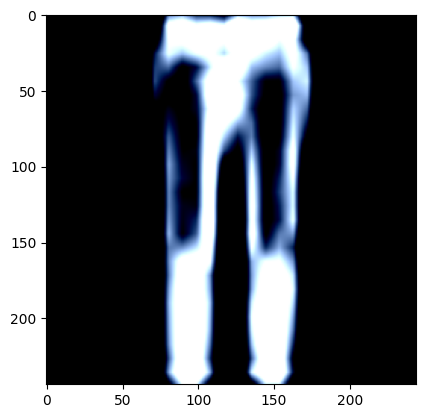

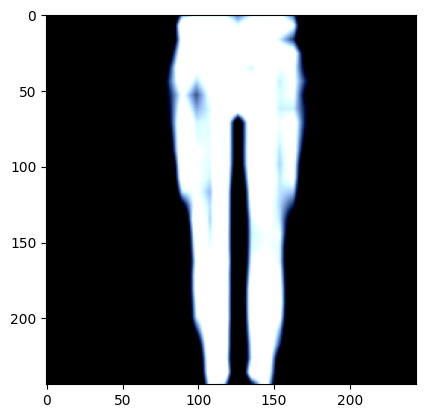

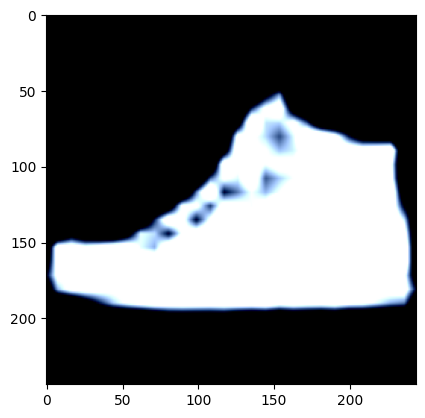

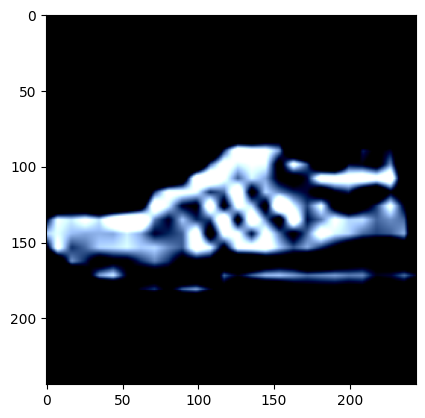

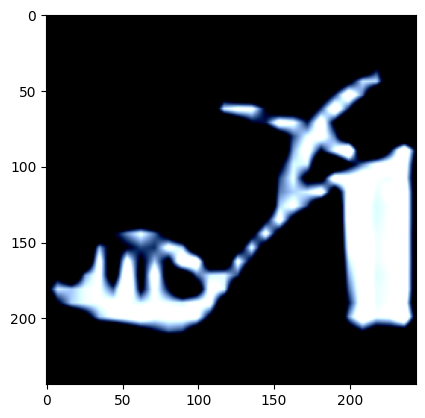

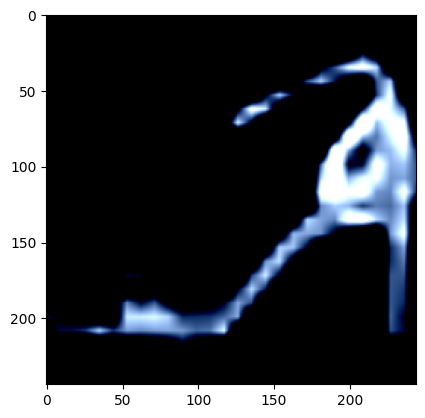

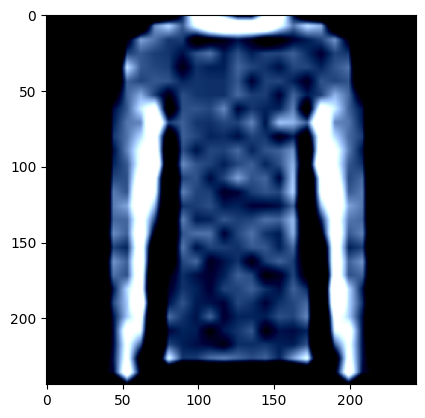

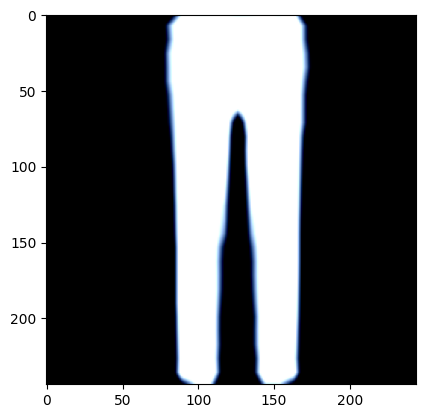

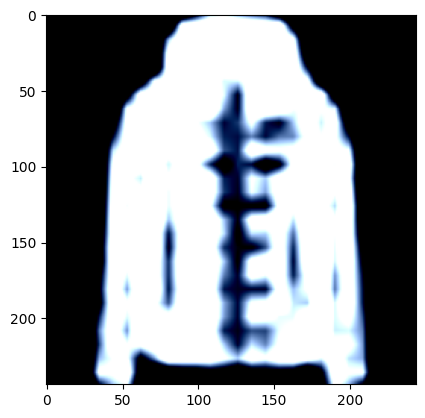

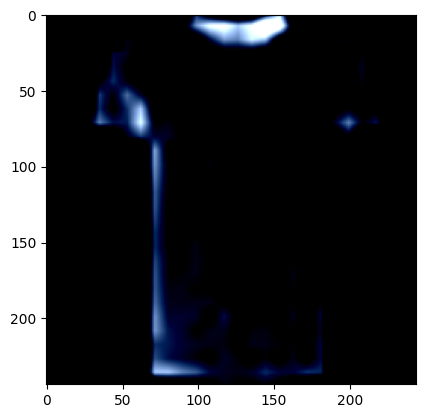

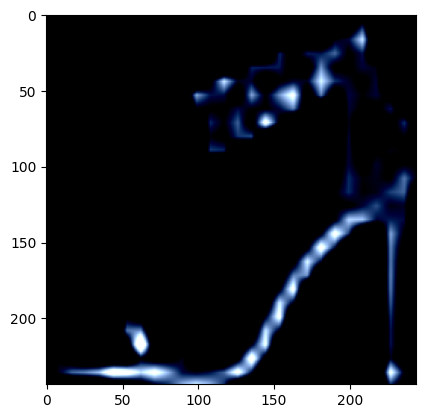

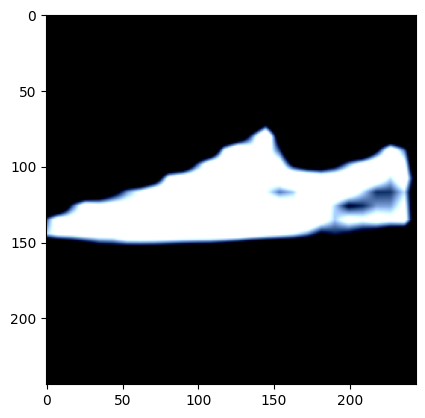

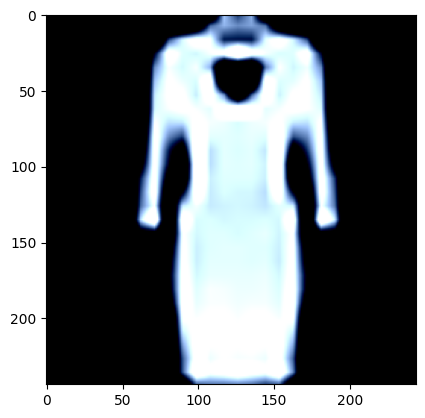

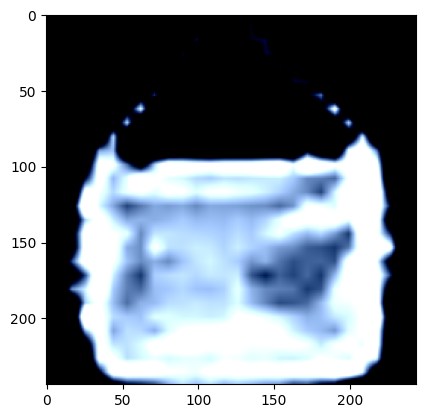

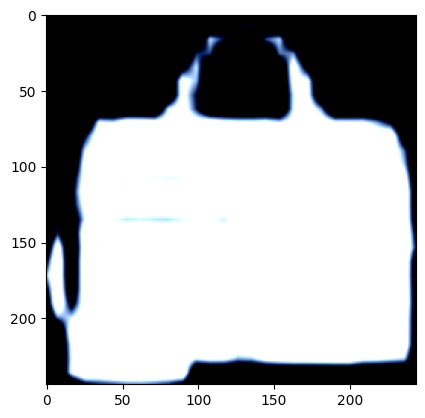

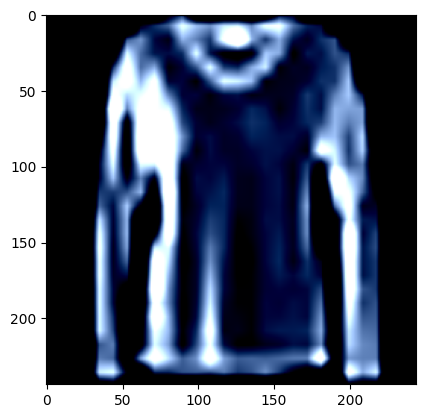

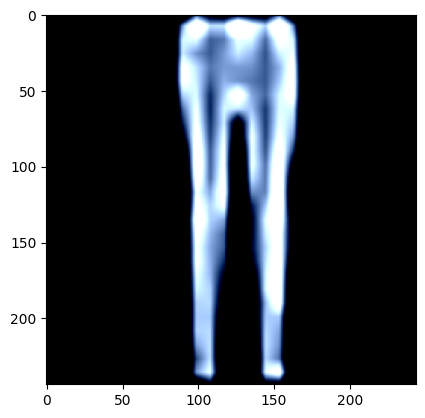

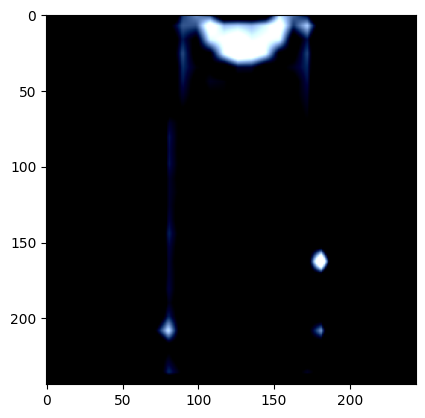

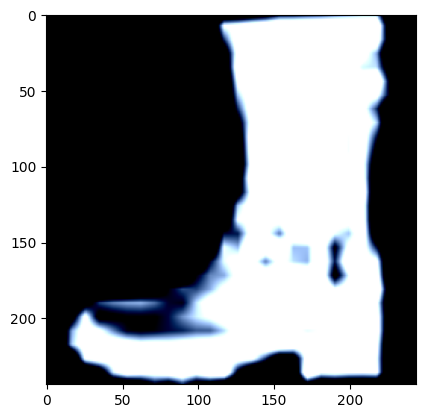

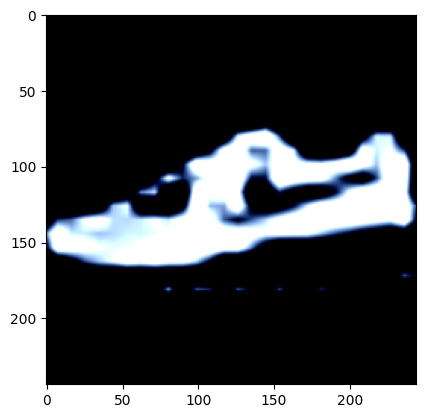

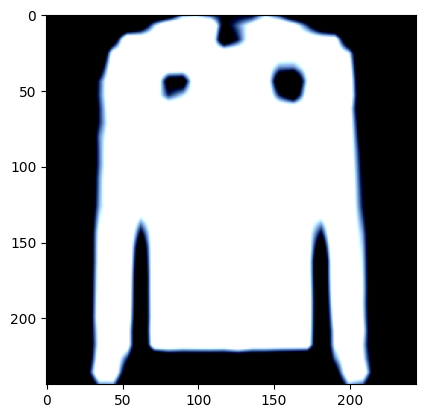

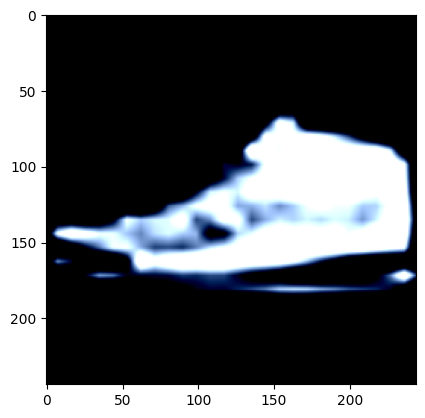

In [41]:
for i in range(16):
  plt.imshow(x1[i].permute(1, 2, 0).cpu().numpy())
  plt.show()
  plt.imshow(x2[i].permute(1, 2, 0).cpu().numpy())
  plt.show()